<a href="https://colab.research.google.com/github/baricio00/Health-Informatics-2025-26/blob/main/survival_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time-to-event models to examine recurrence-free survival and overall survival

kaplan maier, fit the model, multivariate analysis, features selection, shonfield residues

In [99]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(1234)
%pip install lifelines
%pip install sklearn
%pip install mlxtend
from lifelines import KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import StandardScaler
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold

df = pd.read_csv('../rotterdam.csv')

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


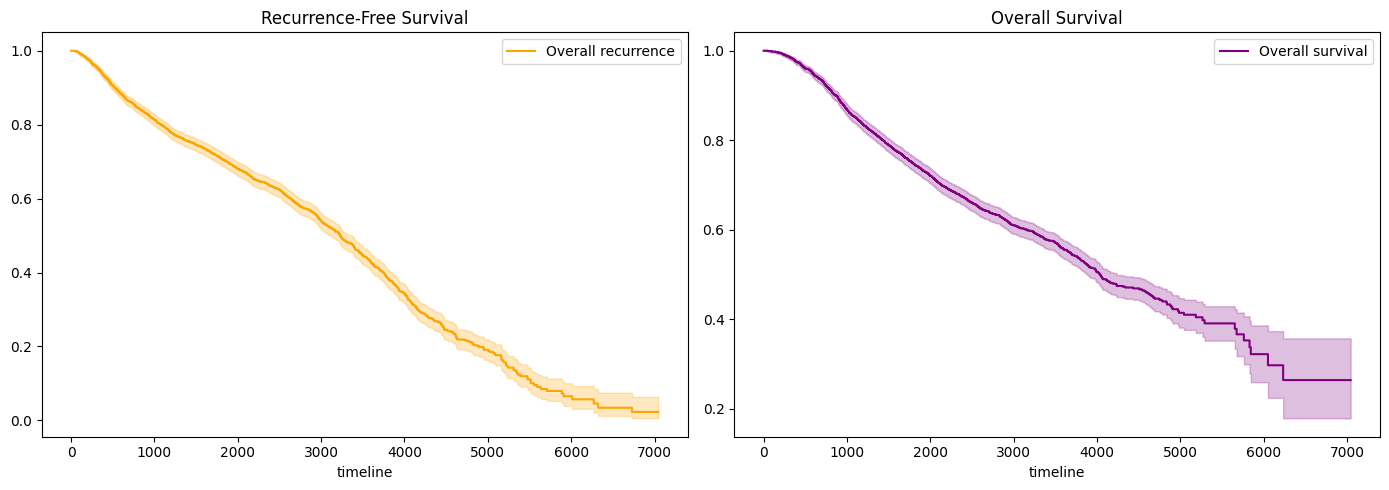

In [79]:
kmf = KaplanMeierFitter()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

kmf.fit(
    durations=df['rtime'],
    event_observed=df['recur'],
    label = 'Overall recurrence'
)
kmf.plot_survival_function(ax=ax1, color='orange')

kmf.fit(
    durations=df['dtime'],
    event_observed=df['death'],
    label = 'Overall survival'
)
kmf.plot_survival_function(ax=ax2, color='purple')

ax1.set_title('Recurrence-Free Survival')
ax2.set_title('Overall Survival')
plt.tight_layout()

In [80]:
print(df['age'].quantile([0.25, 0.5, 0.75]))

0.25   45.00
0.50   54.00
0.75   65.00
Name: age, dtype: float64


In [81]:
# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df['er_cat'] = np.where(df['er'] >= 10, 1, 0)
df['pgr_cat'] = np.where(df['pgr'] >= 10, 1, 0)

node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df['nodes_cat'] = pd.cut(df['nodes'], bins=node_bins, labels=node_labels, right=True)

df['age_bin'] = pd.cut(df['age'], bins=[45, 54, 64, 1000], labels=['<45', '45-64', '>64'])

num_features = ['grade', 'age']
cat_features = ['er_cat', 'pgr_cat', 'chemo', 'hormon', 'size', 'nodes_cat', 'age_bin']

df_clean = df.copy()

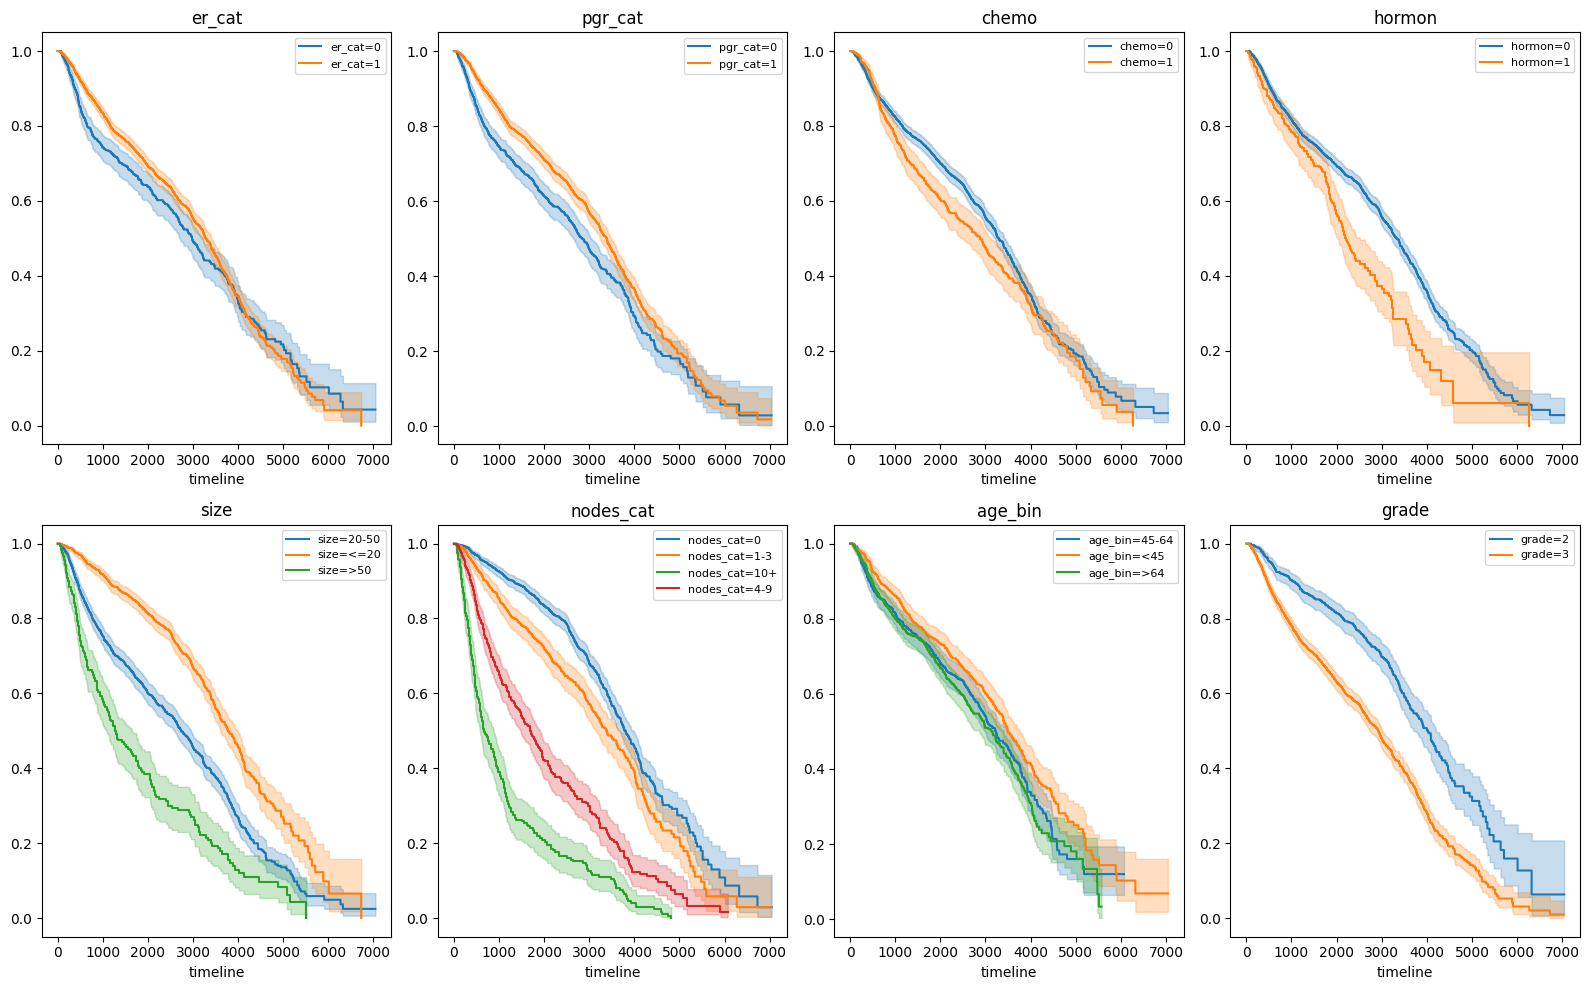

In [82]:
# Create a grid of subplots for all covariates
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, covariate in enumerate(cat_features + ['grade']):
    # Ensure only non-NaN unique values are sorted to avoid TypeError
    covariate_values = np.sort(df_clean[covariate].dropna().unique())

    for value in covariate_values:
        mask = df_clean[covariate] == value
        kmf.fit(
            df_clean.loc[mask, 'rtime'],
            event_observed=df_clean.loc[mask, 'recur'],
            label=f'{covariate}={value}'
        )
        kmf.plot_survival_function(ax=axes[idx])

    axes[idx].set_title(f'{covariate}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

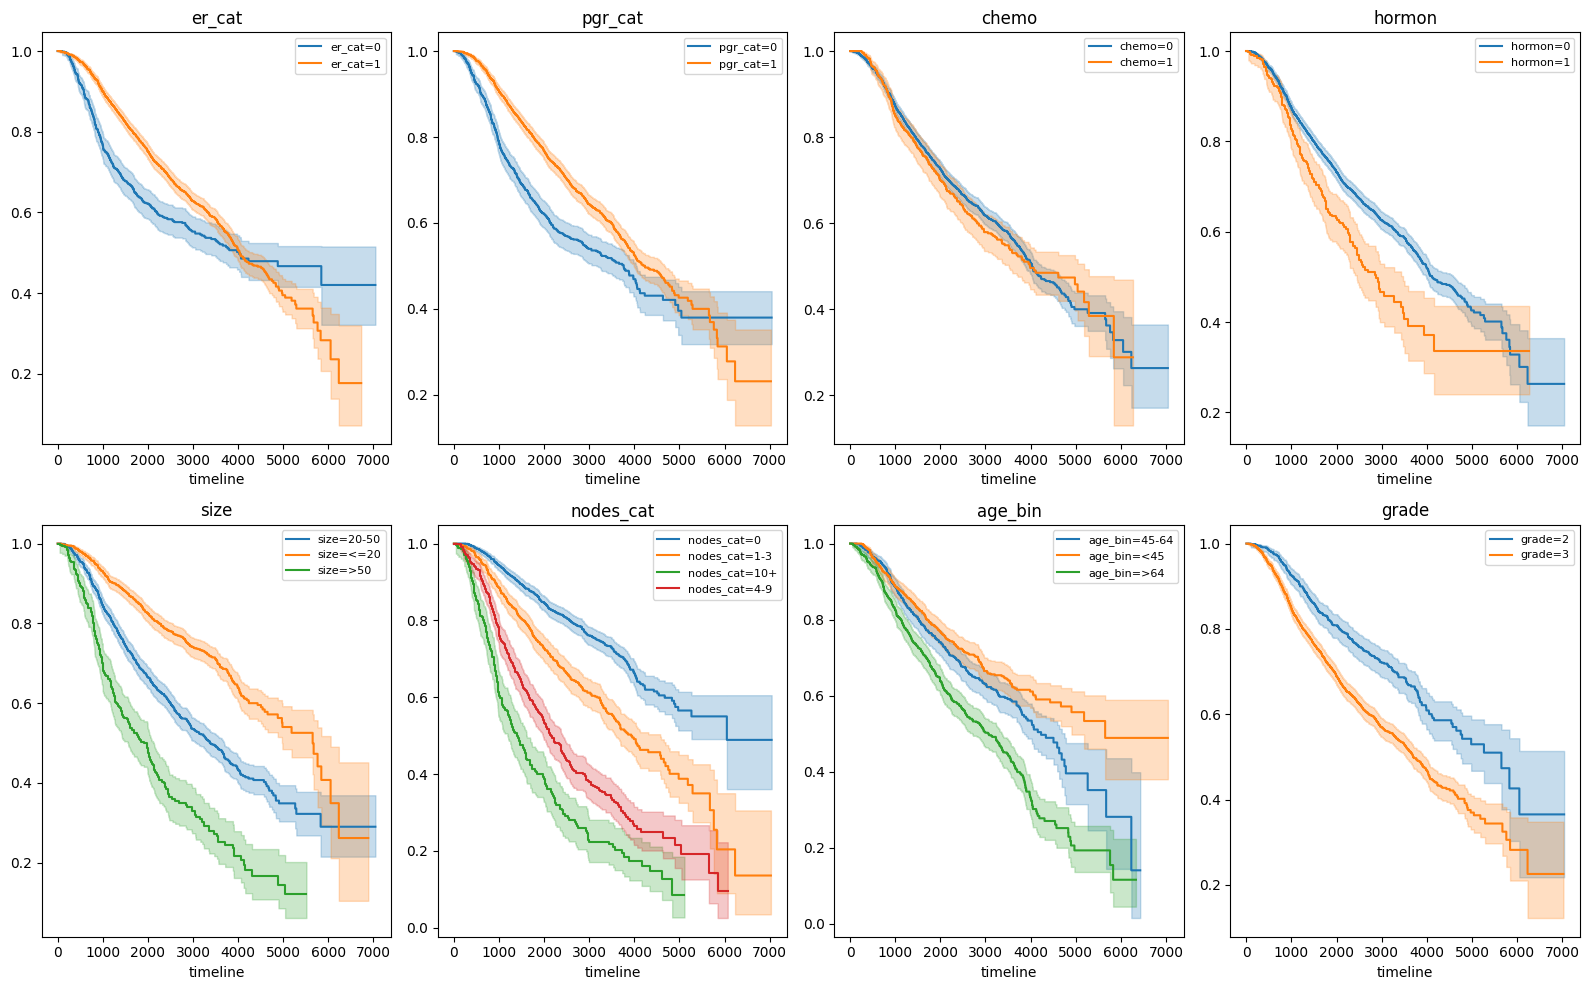

In [83]:
# Create a grid of subplots for all covariates
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, covariate in enumerate(cat_features + ['grade']):
    # Ensure only non-NaN unique values are sorted to avoid TypeError
    covariate_values = np.sort(df_clean[covariate].dropna().unique())

    for value in covariate_values:
        mask = df_clean[covariate] == value
        kmf.fit(
            df_clean.loc[mask, 'dtime'],
            event_observed=df_clean.loc[mask, 'death'],
            label=f'{covariate}={value}'
        )
        kmf.plot_survival_function(ax=axes[idx])

    axes[idx].set_title(f'{covariate}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

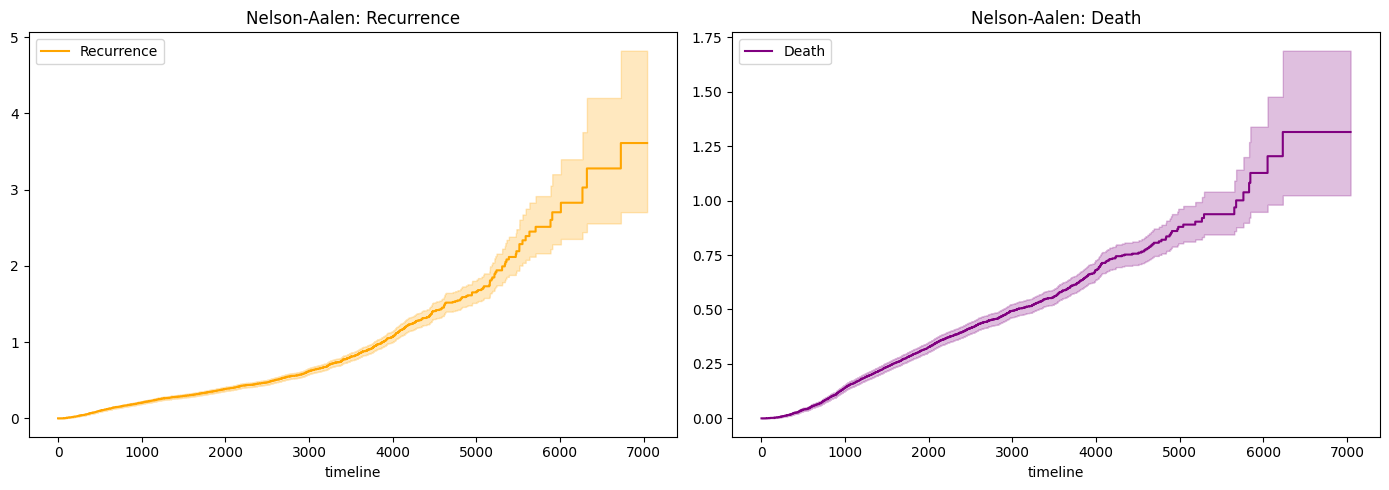

In [84]:
naf = NelsonAalenFitter()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

naf.fit(df['rtime'], event_observed=df['recur'], label='Recurrence')
naf.plot_cumulative_hazard(ax=ax1, color='orange')
ax1.set_title('Nelson-Aalen: Recurrence')

naf.fit(df['dtime'], event_observed=df['death'], label='Death')
naf.plot_cumulative_hazard(ax=ax2, color='purple')
ax2.set_title('Nelson-Aalen: Death')

plt.tight_layout()
plt.show()

In [85]:
from lifelines import CoxPHFitter
# Check if 'age_bin' exists in cat_features before attempting to remove it

df_clean_rfs=df_clean[cat_features + ['rtime', 'recur', 'grade']]
df_clean_rfs=df_clean_rfs.dropna() # Drop rows with NaN values

# Identify categorical columns that need one-hot encoding
categorical_cols_to_encode = ['size', 'nodes_cat', 'hormon', 'chemo', 'pgr_cat', 'er_cat', 'age_bin']

scaler = StandardScaler()
df_clean_rfs['grade'] = scaler.fit_transform(df_clean_rfs[['grade']])

# One-hot encode these categorical columns
df_clean_rfs = pd.get_dummies(df_clean_rfs, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, drop_first=True, dtype=int)

In [86]:
df_clean_os=df_clean[cat_features + ['dtime', 'death', 'grade']]
df_clean_os=df_clean_os.dropna() # Drop rows with NaN values

# Identify categorical columns that need one-hot encoding
categorical_cols_to_encode = ['size', 'nodes_cat', 'hormon', 'chemo', 'pgr_cat', 'er_cat', 'age_bin']

scaler = StandardScaler()
df_clean_os['grade'] = scaler.fit_transform(df_clean_os[['grade']])

# One-hot encode these categorical columns
df_clean_os = pd.get_dummies(df_clean_os, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, drop_first=True, dtype=int)

# Cox model

## First model with every variable

In [87]:
# Recurrence-free survival (time to recurrence/censoring)
df_clean_rfs = df_clean_rfs.reset_index(drop=True)
cph_rfs = CoxPHFitter()
cph_rfs.fit(df_clean_rfs, duration_col="rtime", event_col="recur")
cph_rfs.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1161 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 1038
   partial log-likelihood = -6776.43
         time fit was run = 2026-02-04 16:08:55 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.22      1.25      0.04            0.15            0.29                1.16                1.34
size_<=20     -0.33      0.72      0.07           -0.47           -0.19                0.62                0.83
size_>50       0.30      1.35      0.09            0.12            0.48                1.13                1.62
nodes_cat_1-3  0.47      1.60      0.09            0.29            0.66                1.33                1.93
nodes_cat_4-9  1.14      3.14      0.10            0.96            1.33                2.60                3.79
nodes_cat_10+  1.76      5.81      0.11            1.55            1.97                4.73                7.14
hormon_1      -0.14      0.87      0.09           -0.32            0.04                0.73                1.04
chemo_1       -0.42      0.66      0.11           -0.64           -0.20                0.53                0.82
pgr_cat_1     -0.19      0.83      0.08           -0.34           -0.04                0.71                0.96
er_cat_1       0.10      1.11      0.09           -0.07            0.27                0.93                1.32
age_bin_45-64  0.01      1.01      0.08           -0.15            0.18                0.86                1.20
age_bin_>64   -0.10      0.91      0.09           -0.27            0.07                0.76                1.08

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  6.20 <0.005     30.70
size_<=20        0.00 -4.53 <0.005     17.36
size_>50         0.00  3.24 <0.005      9.73
nodes_cat_1-3    0.00  4.98 <0.005     20.59
nodes_cat_4-9    0.00 11.90 <0.005    106.02
nodes_cat_10+    0.00 16.75 <0.005    206.86
hormon_1         0.00 -1.50   0.13      2.89
chemo_1          0.00 -3.79 <0.005     12.69
pgr_cat_1        0.00 -2.46   0.01      6.16
er_cat_1         0.00  1.18   0.24      2.07
age_bin_45-64    0.00  0.16   0.87      0.19
age_bin_>64      0.00 -1.12   0.26      1.92
---
Concordance = 0.74
Partial AIC = 13576.86
log-likelihood ratio test = 581.61 on 12 df
-log2(p) of ll-ratio test = 385.50

In [88]:
# Overall survival (time to death/censoring)
df_clean_os = df_clean_os.reset_index(drop=True)
cph_os = CoxPHFitter()
cph_os.fit(df_clean_os, duration_col="dtime", event_col="death")
cph_os.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1232 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 967
   partial log-likelihood = -6668.23
         time fit was run = 2026-02-04 16:08:57 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.15      1.16      0.04            0.08            0.22                1.08                1.24
size_<=20     -0.31      0.74      0.08           -0.46           -0.15                0.63                0.86
size_>50       0.33      1.40      0.09            0.16            0.51                1.17                1.67
nodes_cat_1-3  0.76      2.14      0.10            0.57            0.95                1.77                2.58
nodes_cat_4-9  1.22      3.40      0.10            1.03            1.41                2.81                4.11
nodes_cat_10+  1.53      4.63      0.11            1.31            1.75                3.72                5.77
hormon_1      -0.29      0.75      0.09           -0.47           -0.10                0.62                0.90
chemo_1       -0.34      0.71      0.12           -0.58           -0.11                0.56                0.90
pgr_cat_1     -0.29      0.75      0.08           -0.45           -0.13                0.64                0.88
er_cat_1      -0.10      0.90      0.09           -0.28            0.08                0.76                1.08
age_bin_45-64  0.04      1.04      0.10           -0.15            0.23                0.86                1.26
age_bin_>64    0.40      1.49      0.09            0.21            0.58                1.24                1.79

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  4.12 <0.005     14.71
size_<=20        0.00 -3.96 <0.005     13.73
size_>50         0.00  3.69 <0.005     12.13
nodes_cat_1-3    0.00  7.96 <0.005     49.03
nodes_cat_4-9    0.00 12.69 <0.005    120.20
nodes_cat_10+    0.00 13.67 <0.005    138.97
hormon_1         0.00 -3.02 <0.005      8.62
chemo_1          0.00 -2.83 <0.005      7.76
pgr_cat_1        0.00 -3.62 <0.005     11.75
er_cat_1         0.00 -1.13   0.26      1.94
age_bin_45-64    0.00  0.44   0.66      0.61
age_bin_>64      0.00  4.24 <0.005     15.45
---
Concordance = 0.72
Partial AIC = 13360.46
log-likelihood ratio test = 522.99 on 12 df
-log2(p) of ll-ratio test = 343.99

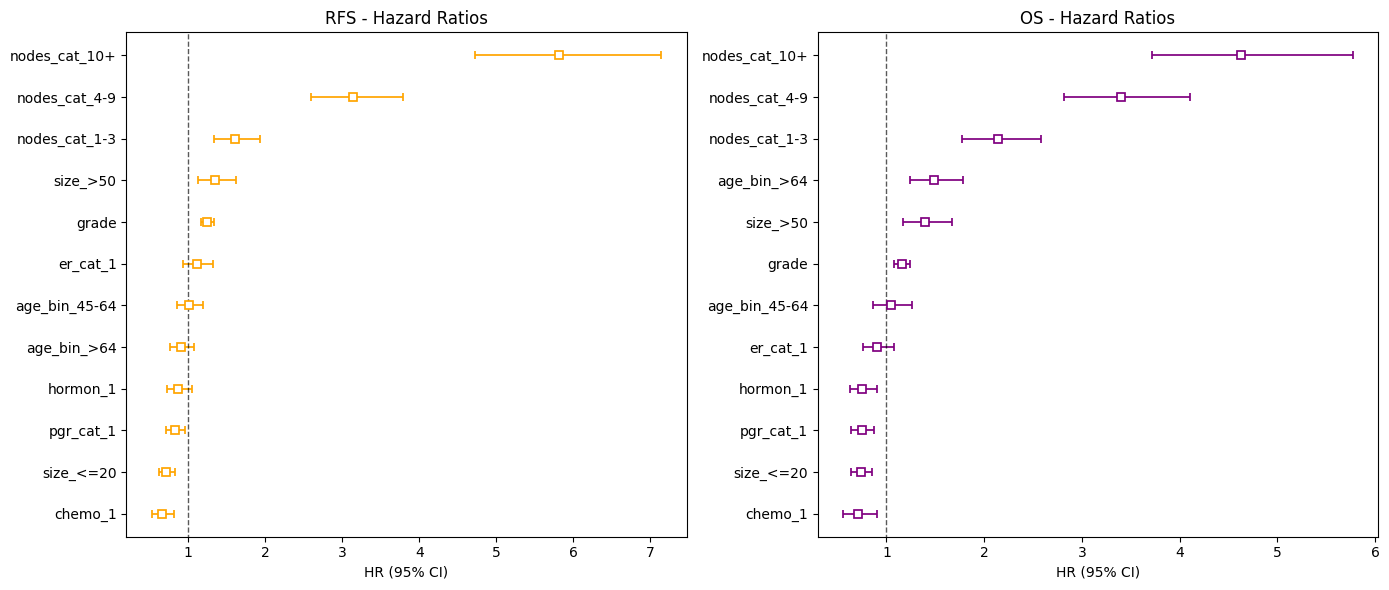

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cph_rfs.plot(hazard_ratios=True, ax=ax1, c='orange')
ax1.set_title('RFS - Hazard Ratios')

cph_os.plot(hazard_ratios=True, ax=ax2, c='purple')
ax2.set_title('OS - Hazard Ratios')

plt.tight_layout()
plt.show()

### Cross-validation

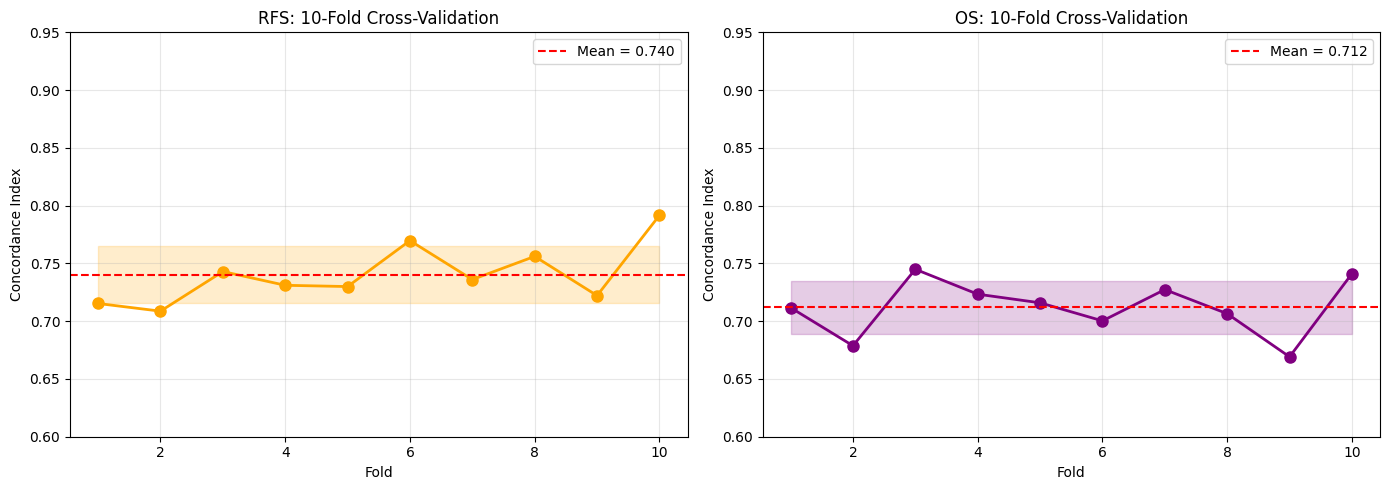


RFS C-index: mean=0.740, sd=0.024
OS C-index: mean=0.712, sd=0.023


In [90]:
# Perform cross-validation for RFS (recurrence)
scores = k_fold_cross_validation(
    cph_rfs,
    df_clean_rfs,
    'rtime',
    event_col='recur',
    k=10,
    scoring_method="concordance_index",
    seed=1234
)

# Visualize cross-validation scores for RFS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='orange', linewidth=2, markersize=8)
ax1.axhline(y=np.mean(scores), color='red', linestyle='--', label=f'Mean = {np.mean(scores):.3f}')
ax1.fill_between(range(1, len(scores) + 1),
                  np.mean(scores) - np.std(scores),
                  np.mean(scores) + np.std(scores),
                  alpha=0.2, color='orange')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Concordance Index')
ax1.set_title('RFS: 10-Fold Cross-Validation')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.6, 0.95]) # Adjusted y-axis limit

# Perform cross-validation for OS (death)
scores_os = k_fold_cross_validation(
    cph_os,
    df_clean_os,
    'dtime',
    event_col='death',
    k=10,
    scoring_method="concordance_index",
    seed=1234
)

ax2.plot(range(1, len(scores_os) + 1), scores_os, marker='o', linestyle='-', color='purple', linewidth=2, markersize=8)
ax2.axhline(y=np.mean(scores_os), color='red', linestyle='--', label=f'Mean = {np.mean(scores_os):.3f}')
ax2.fill_between(range(1, len(scores_os) + 1),
                  np.mean(scores_os) - np.std(scores_os),
                  np.mean(scores_os) + np.std(scores_os),
                  alpha=0.2, color='purple')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Concordance Index')
ax2.set_title('OS: 10-Fold Cross-Validation')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.6, 0.95]) # Adjusted y-axis limit

plt.tight_layout()
plt.show()

print(f"\nRFS C-index: mean={np.mean(scores):.3f}, sd={np.std(scores):.3f}")
print(f"OS C-index: mean={np.mean(scores_os):.3f}, sd={np.std(scores_os):.3f}")

## Forward, Backward and Best subset selection

In [91]:
from sklearn.model_selection import KFold
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis

cv = KFold(n_splits=5, shuffle=True, random_state=42)

covariates_rfs = [c for c in df_clean_rfs.columns if c not in ['rtime', 'recur']]
covariates_os = [c for c in df_clean_os.columns if c not in ['dtime', 'death']]

X_rfs = df_clean_rfs[covariates_rfs]
y_rfs = Surv.from_dataframe('recur', 'rtime', df_clean_rfs)

X_os = df_clean_os[covariates_os]
y_os = Surv.from_dataframe('death', 'dtime', df_clean_os)

cox_rfs = CoxPHSurvivalAnalysis()
cox_rfs.fit(X_rfs, y_rfs)
cox_os = CoxPHSurvivalAnalysis()
cox_os.fit(X_os, y_os)

CoxPHSurvivalAnalysis()

### Forward selection

In [92]:
sfs_forward_rfs = SequentialFeatureSelector(
    estimator=cox_rfs,
    n_features_to_select="auto",
    direction="forward",
    cv=cv,
)

sfs_forward_rfs.fit(X_rfs, y_rfs)

selected_forward_rfs = X_rfs.columns[sfs_forward_rfs.get_support()].tolist()
print("RFS - Forward selection:", selected_forward_rfs)

sfs_forward_os = SequentialFeatureSelector(
    estimator=cox_os,
    n_features_to_select="auto",
    direction="forward",
    cv=cv,
)

sfs_forward_os.fit(X_os, y_os)

selected_forward_os = X_os.columns[sfs_forward_os.get_support()].tolist()
print("\nOS - Forward selection:", selected_forward_os)

RFS - Forward selection: ['grade', 'size_<=20', 'nodes_cat_1-3', 'nodes_cat_4-9', 'nodes_cat_10+', 'pgr_cat_1']

OS - Forward selection: ['size_<=20', 'nodes_cat_1-3', 'nodes_cat_4-9', 'nodes_cat_10+', 'pgr_cat_1', 'age_bin_>64']


In [93]:
from lifelines.utils import k_fold_cross_validation
from lifelines import CoxPHFitter

# For RFS
# Prepare the DataFrame for k_fold_cross_validation
df_rfs_cv = pd.concat([X_rfs[selected_forward_rfs], df_clean_rfs[['rtime', 'recur']]], axis=1)

cv_scores_forward_rfs = k_fold_cross_validation(
    CoxPHFitter(), # Unfitted estimator
    df_rfs_cv,
    duration_col='rtime',
    event_col='recur',
    k=cv.get_n_splits(), # Use the number of splits from the KFold object
    scoring_method="concordance_index",
    seed=1234
)
print("RFS - Forward selection - CV c-index: ",
      f"{np.mean(cv_scores_forward_rfs):.4f} \u00b1 {np.std(cv_scores_forward_rfs):.4f}")

# For OS
# Prepare the DataFrame for k_fold_cross_validation
df_os_cv = pd.concat([X_os[selected_forward_os], df_clean_os[['dtime', 'death']]], axis=1)

cv_scores_forward_os = k_fold_cross_validation(
    CoxPHFitter(), # Unfitted estimator
    df_os_cv,
    duration_col='dtime',
    event_col='death',
    k=cv.get_n_splits(), # Use the number of splits from the KFold object
    scoring_method="concordance_index",
    seed=1234
)
print("OS - Forward selection - CV c-index: ",
      f"{np.mean(cv_scores_forward_os):.4f} \u00b1 {np.std(cv_scores_forward_os):.4f}")

RFS - Forward selection - CV c-index:  0.7405 ± 0.0126
OS - Forward selection - CV c-index:  0.7050 ± 0.0147


### Backward

In [94]:
sfs_backward_rfs = SequentialFeatureSelector(
    estimator=cox_rfs,
    n_features_to_select="auto",
    direction="backward",
    cv=cv,
)

sfs_backward_rfs.fit(X_rfs, y_rfs)

selected_backward_rfs = X_rfs.columns[sfs_backward_rfs.get_support()].tolist()
print("RFS - Backward selection:", selected_forward_rfs)

sfs_backward_os = SequentialFeatureSelector(
    estimator=cox_os,
    n_features_to_select="auto",
    direction="backward",
    cv=cv,
)

sfs_backward_os.fit(X_os, y_os)

selected_backward_os = X_os.columns[sfs_backward_os.get_support()].tolist()
print("OS - Backward selection:", selected_backward_os)

RFS - Backward selection: ['grade', 'size_<=20', 'nodes_cat_1-3', 'nodes_cat_4-9', 'nodes_cat_10+', 'pgr_cat_1']
OS - Backward selection: ['size_<=20', 'nodes_cat_1-3', 'nodes_cat_4-9', 'nodes_cat_10+', 'pgr_cat_1', 'age_bin_>64']


In [95]:
# For RFS
# Prepare the DataFrame for k_fold_cross_validation
df_rfs_cv = pd.concat([X_rfs[selected_backward_rfs], df_clean_rfs[['rtime', 'recur']]], axis=1)

cv_scores_backward_rfs = k_fold_cross_validation(
    CoxPHFitter(), # Unfitted estimator
    df_rfs_cv,
    duration_col='rtime',
    event_col='recur',
    k=cv.get_n_splits(), # Use the number of splits from the KFold object
    scoring_method="concordance_index",
    seed=12345
)
print("RFS - Backward selection - CV c-index: ",
      f"{np.mean(cv_scores_backward_rfs):.4f} \u00b1 {np.std(cv_scores_backward_rfs):.4f}")

# For OS
# Prepare the DataFrame for k_fold_cross_validation
df_os_cv = pd.concat([X_os[selected_backward_os], df_clean_os[['dtime', 'death']]], axis=1)

cv_scores_backward_os = k_fold_cross_validation(
    CoxPHFitter(), # Unfitted estimator
    df_os_cv,
    duration_col='dtime',
    event_col='death',
    k=cv.get_n_splits(), # Use the number of splits from the KFold object
    scoring_method="concordance_index",
    seed=1234
)
print("OS - Backward selection - CV c-index: ",
      f"{np.mean(cv_scores_backward_os):.4f} \u00b1 {np.std(cv_scores_backward_os):.4f}")

RFS - Backward selection - CV c-index:  0.7385 ± 0.0249
OS - Backward selection - CV c-index:  0.7050 ± 0.0147


### Best subset

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

efs_rfs = EFS(
    estimator=cox_rfs,
    min_features=2,
    max_features=7,
    scoring=lambda est, X_sub, y_sub: est.score(X_sub, y_sub),
    cv=cv,
    print_progress=True,
)

efs_rfs = efs_rfs.fit(X_rfs, y_rfs)

best_idx_rfs = list(efs_rfs.best_idx_) # indexes of the selected features
best_subset_rfs = [covariates_rfs[i] for i in best_idx_rfs]

print("RFS - Best subset:", best_subset_rfs)
print("RFS - Best CV c-index:", efs_rfs.best_score_)

efs_os = EFS(
    estimator=cox_os,
    min_features=2,
    max_features=len(covariates_os),
    scoring=lambda est, X_sub, y_sub: est.score(X_sub, y_sub),
    cv=cv,
    print_progress=True,
)

efs_os = efs_os.fit(X_os, y_os)

best_idx_os = list(efs_os.best_idx_) # indexes of the selected features
best_subset_os = [covariates_os[i] for i in best_idx_os]

print("\nOS - Best subset:", best_subset_os)
print("OS - Best CV c-index:", efs_os.best_score_)

## Model with selected variables + cross validation

In [127]:
df_forward_rfs = df_clean_rfs[selected_forward_rfs + ['rtime', 'recur']].dropna()
df_forward_os = df_clean_os[selected_forward_os + ['dtime', 'death']].dropna()

df_backward_rfs = df_clean_rfs[selected_backward_rfs + ['rtime', 'recur']].dropna()
df_backward_os = df_clean_os[selected_backward_os + ['dtime', 'death']].dropna()

# df_best_rfs = df_clean_rfs[selected_best_rfs + ['rtime', 'recur']].dropna()
# df_best_os = df_clean_os[selected_best_os + ['dtime', 'death']].dropna()

### Forward

In [128]:
cph_forward_rfs = CoxPHFitter()
cph_forward_rfs.fit(df_forward_rfs, duration_col = 'rtime', event_col = 'recur')
cph_forward_rfs.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1161 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 1038
   partial log-likelihood = -6791.81
         time fit was run = 2026-02-04 17:01:21 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.23      1.26      0.04            0.16            0.30                1.17                1.35
size_<=20     -0.39      0.68      0.07           -0.52           -0.25                0.59                0.78
nodes_cat_1-3  0.31      1.36      0.08            0.14            0.48                1.15                1.61
nodes_cat_4-9  1.05      2.86      0.09            0.88            1.22                2.41                3.39
nodes_cat_10+  1.66      5.26      0.10            1.47            1.85                4.35                6.34
pgr_cat_1     -0.14      0.87      0.07           -0.27           -0.01                0.77                0.99

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  6.43 <0.005     32.83
size_<=20        0.00 -5.52 <0.005     24.78
nodes_cat_1-3    0.00  3.64 <0.005     11.86
nodes_cat_4-9    0.00 12.12 <0.005    109.84
nodes_cat_10+    0.00 17.29 <0.005    220.04
pgr_cat_1        0.00 -2.05   0.04      4.65
---
Concordance = 0.74
Partial AIC = 13595.62
log-likelihood ratio test = 550.85 on 6 df
-log2(p) of ll-ratio test = 382.13

<Axes: xlabel='HR (95% CI)'>

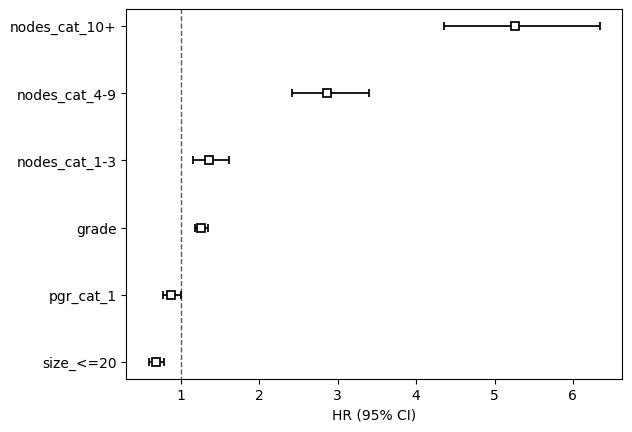

In [129]:
cph_forward_rfs.plot(hazard_ratios=True)

In [130]:
cph_forward_os = CoxPHFitter()
cph_forward_os.fit(df_forward_os, duration_col = 'dtime', event_col = 'death')
cph_forward_os.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1232 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 967
   partial log-likelihood = -6693.50
         time fit was run = 2026-02-04 17:01:28 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
size_<=20     -0.40      0.67      0.07           -0.55           -0.26                0.58                0.77
nodes_cat_1-3  0.62      1.86      0.09            0.45            0.79                1.57                2.21
nodes_cat_4-9  1.13      3.10      0.09            0.95            1.31                2.60                3.69
nodes_cat_10+  1.47      4.35      0.10            1.27            1.67                3.55                5.34
pgr_cat_1     -0.34      0.71      0.07           -0.47           -0.21                0.62                0.81
age_bin_>64    0.47      1.59      0.07            0.34            0.59                1.40                1.81

               cmp to     z      p  -log2(p)
covariate                                   
size_<=20        0.00 -5.47 <0.005     24.41
nodes_cat_1-3    0.00  7.11 <0.005     39.62
nodes_cat_4-9    0.00 12.61 <0.005    118.77
nodes_cat_10+    0.00 14.09 <0.005    147.28
pgr_cat_1        0.00 -5.02 <0.005     20.90
age_bin_>64      0.00  7.10 <0.005     39.52
---
Concordance = 0.71
Partial AIC = 13399.01
log-likelihood ratio test = 472.44 on 6 df
-log2(p) of ll-ratio test = 326.01

<Axes: xlabel='HR (95% CI)'>

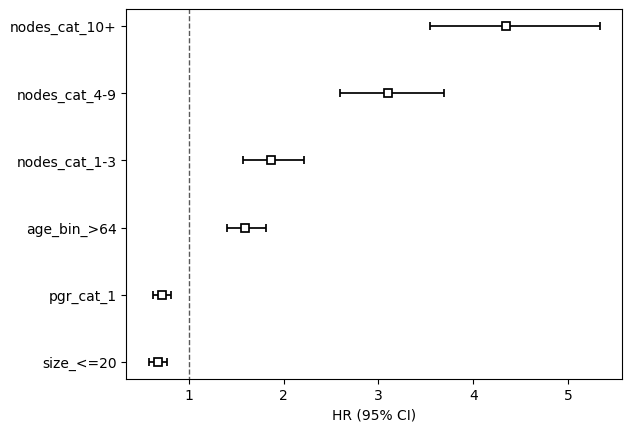

In [131]:
cph_forward_os.plot(hazard_ratios=True)

In [132]:
features_forward_rfs = df_forward_rfs.columns.to_list().copy()
scores_forward_rfs = k_fold_cross_validation(cph_forward_rfs, df_forward_rfs[features_forward_rfs], 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_forward_rfs

print("RFS -", np.mean(scores_forward_rfs), np.std(scores_forward_rfs))

features_forward_os = df_clean_os.columns.to_list().copy()
scores_forward_os = k_fold_cross_validation(cph_os, df_clean_os[features_forward_os], 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_forward_os

print("OS -", np.mean(scores_forward_os), np.std(scores_forward_os))

RFS - 0.7408391473535261 0.020362848121049663
OS - 0.7119025764051496 0.023282053953029642


<Axes: xlabel='HR (95% CI)'>

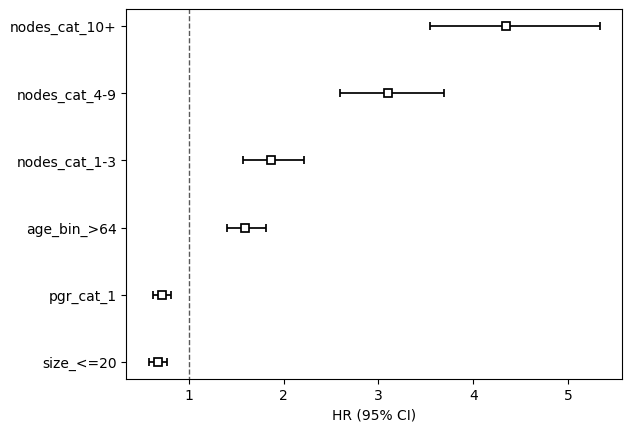

In [133]:
cph_forward_os.plot(hazard_ratios=True)

### Backward

In [134]:
cph_backward_rfs = CoxPHFitter()
cph_backward_rfs.fit(df_backward_rfs, duration_col = 'rtime', event_col = 'recur')
cph_backward_rfs.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1161 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 1038
   partial log-likelihood = -6791.81
         time fit was run = 2026-02-04 17:01:47 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.23      1.26      0.04            0.16            0.30                1.17                1.35
size_<=20     -0.39      0.68      0.07           -0.52           -0.25                0.59                0.78
nodes_cat_1-3  0.31      1.36      0.08            0.14            0.48                1.15                1.61
nodes_cat_4-9  1.05      2.86      0.09            0.88            1.22                2.41                3.39
nodes_cat_10+  1.66      5.26      0.10            1.47            1.85                4.35                6.34
pgr_cat_1     -0.14      0.87      0.07           -0.27           -0.01                0.77                0.99

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  6.43 <0.005     32.83
size_<=20        0.00 -5.52 <0.005     24.78
nodes_cat_1-3    0.00  3.64 <0.005     11.86
nodes_cat_4-9    0.00 12.12 <0.005    109.84
nodes_cat_10+    0.00 17.29 <0.005    220.04
pgr_cat_1        0.00 -2.05   0.04      4.65
---
Concordance = 0.74
Partial AIC = 13595.62
log-likelihood ratio test = 550.85 on 6 df
-log2(p) of ll-ratio test = 382.13

<Axes: xlabel='HR (95% CI)'>

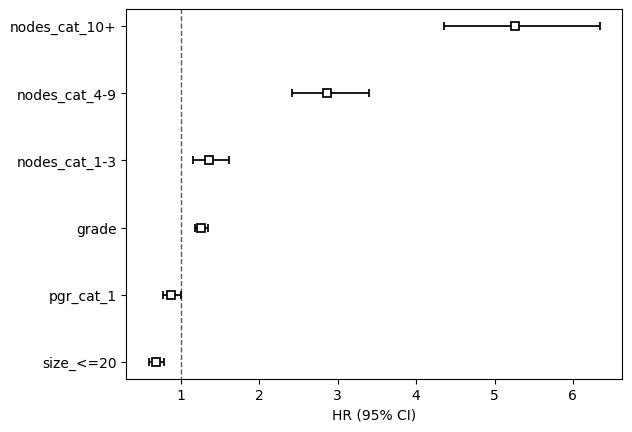

In [135]:
cph_backward_rfs.plot(hazard_ratios=True)

In [136]:
cph_backward_os = CoxPHFitter()
cph_backward_os.fit(df_backward_os, duration_col = 'dtime', event_col = 'death')
cph_backward_os.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1232 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 967
   partial log-likelihood = -6693.50
         time fit was run = 2026-02-04 17:01:53 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
size_<=20     -0.40      0.67      0.07           -0.55           -0.26                0.58                0.77
nodes_cat_1-3  0.62      1.86      0.09            0.45            0.79                1.57                2.21
nodes_cat_4-9  1.13      3.10      0.09            0.95            1.31                2.60                3.69
nodes_cat_10+  1.47      4.35      0.10            1.27            1.67                3.55                5.34
pgr_cat_1     -0.34      0.71      0.07           -0.47           -0.21                0.62                0.81
age_bin_>64    0.47      1.59      0.07            0.34            0.59                1.40                1.81

               cmp to     z      p  -log2(p)
covariate                                   
size_<=20        0.00 -5.47 <0.005     24.41
nodes_cat_1-3    0.00  7.11 <0.005     39.62
nodes_cat_4-9    0.00 12.61 <0.005    118.77
nodes_cat_10+    0.00 14.09 <0.005    147.28
pgr_cat_1        0.00 -5.02 <0.005     20.90
age_bin_>64      0.00  7.10 <0.005     39.52
---
Concordance = 0.71
Partial AIC = 13399.01
log-likelihood ratio test = 472.44 on 6 df
-log2(p) of ll-ratio test = 326.01

<Axes: xlabel='HR (95% CI)'>

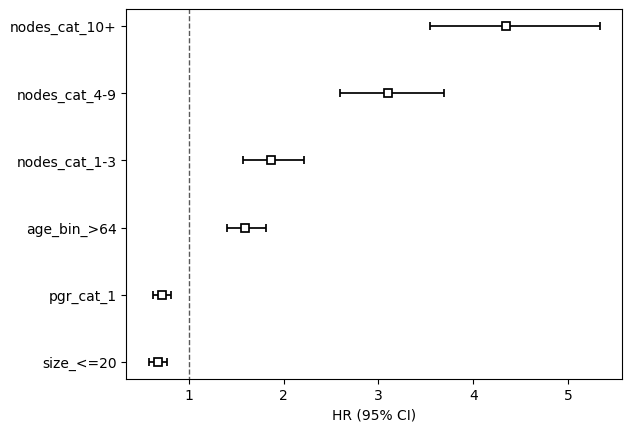

In [137]:
cph_backward_os.plot(hazard_ratios=True)

In [138]:
features_backward_rfs = df_backward_rfs.columns.to_list().copy()
scores_backward_rfs = k_fold_cross_validation(cph_backward_rfs, df_backward_rfs[features_backward_rfs], 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_backward_rfs

print("RFS -", np.mean(scores_backward_rfs), np.std(scores_backward_rfs))

features_backward_os = df_clean_os.columns.to_list().copy()
scores_backward_os = k_fold_cross_validation(cph_os, df_clean_os[features_backward_os], 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_backward_os

print("OS -", np.mean(scores_backward_os), np.std(scores_backward_os))

RFS - 0.7408391473535261 0.020362848121049663
OS - 0.7119025764051496 0.023282053953029642


### Best subset

In [ ]:
cph_best_rfs = CoxPHFitter()
cph_best_rfs.fit(df_best_rfs, duration_col = 'rtime', event_col = 'recur')
cph_best_rfs.print_summary()

In [ ]:
cph_best_os = CoxPHFitter()
cph_best_os.fit(df_best_os, duration_col = 'dtime', event_col = 'death')
cph_best_os.print_summary()

In [ ]:
features_best_rfs = df_best_rfs.columns.to_list().copy()
scores_best_rfs = k_fold_cross_validation(cph_best_rfs, df_best_rfs[features_best_rfs], 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_best_rfs

print("RFS -", np.mean(scores_best_rfs), np.std(scores_best_rfs))

features_best_os = df_clean_os.columns.to_list().copy()
scores_best_os = k_fold_cross_validation(cph_os, df_clean_os[features_best_os], 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_best_os

print("OS -", np.mean(scores_best_os), np.std(scores_best_os))

## Penalization

In [139]:
cph_rfs_penalized = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # penalizer is alpha, l1_ratio is lambda in the equation above
cph_rfs_penalized.fit(df_backward_rfs, duration_col = 'rtime', event_col = 'recur')
cph_rfs_penalized.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1161 right-censored observations>
             duration col = 'rtime'
                event col = 'recur'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 1038
   partial log-likelihood = -7004.15
         time fit was run = 2026-02-04 17:02:18 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
grade          0.05      1.05      0.03           -0.01            0.11                0.99                1.11
size_<=20     -0.18      0.83      0.07           -0.31           -0.05                0.73                0.95
nodes_cat_1-3 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
nodes_cat_4-9  0.38      1.46      0.09            0.20            0.55                1.23                1.74
nodes_cat_10+  1.03      2.80      0.10            0.83            1.23                2.29                3.41
pgr_cat_1     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

               cmp to     z      p  -log2(p)
covariate                                   
grade            0.00  1.49   0.14      2.87
size_<=20        0.00 -2.73   0.01      7.31
nodes_cat_1-3    0.00 -0.00   1.00      0.00
nodes_cat_4-9    0.00  4.25 <0.005     15.53
nodes_cat_10+    0.00 10.11 <0.005     77.39
pgr_cat_1        0.00 -0.01   1.00      0.01
---
Concordance = 0.73
Partial AIC = 14020.31
log-likelihood ratio test = 126.16 on 6 df
-log2(p) of ll-ratio test = 80.00

<Axes: xlabel='HR (95% CI)'>

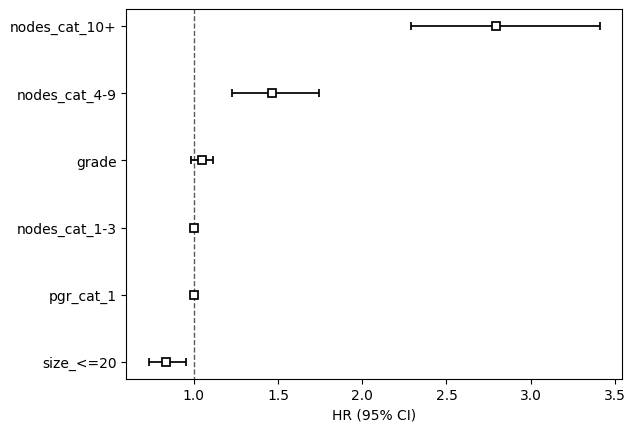

In [140]:
cph_rfs_penalized.plot(hazard_ratios=True)

In [141]:
cph_os_penalized = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # penalizer is alpha, l1_ratio is lambda in the equation above
cph_os_penalized.fit(df_backward_os, duration_col = 'dtime', event_col = 'death')
cph_os_penalized.print_summary()

<lifelines.CoxPHFitter: fitted with 2199 total observations, 1232 right-censored observations>
             duration col = 'dtime'
                event col = 'death'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 2199
number of events observed = 967
   partial log-likelihood = -6901.72
         time fit was run = 2026-02-04 17:02:33 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
size_<=20     -0.23      0.80      0.07           -0.36           -0.09                0.70                0.91
nodes_cat_1-3  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
nodes_cat_4-9  0.34      1.40      0.09            0.17            0.51                1.19                1.66
nodes_cat_10+  0.53      1.69      0.11            0.31            0.75                1.36                2.11
pgr_cat_1     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
age_bin_>64    0.04      1.04      0.07           -0.09            0.18                0.91                1.19

               cmp to     z      p  -log2(p)
covariate                                   
size_<=20        0.00 -3.33 <0.005     10.16
nodes_cat_1-3    0.00  0.00   1.00      0.00
nodes_cat_4-9    0.00  3.94 <0.005     13.56
nodes_cat_10+    0.00  4.67 <0.005     18.31
pgr_cat_1        0.00 -0.01   1.00      0.01
age_bin_>64      0.00  0.59   0.55      0.85
---
Concordance = 0.70
Partial AIC = 13815.45
log-likelihood ratio test = 56.00 on 6 df
-log2(p) of ll-ratio test = 31.68

<Axes: xlabel='HR (95% CI)'>

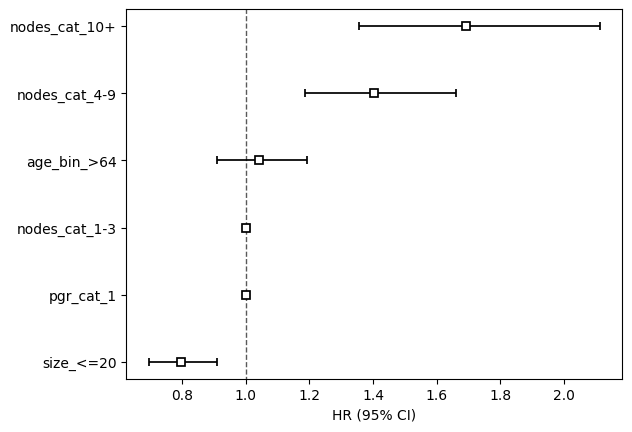

In [142]:
cph_os_penalized.plot(hazard_ratios=True)

### Schoenfeld's residuals and test

In [143]:
cph_forward_rfs.check_assumptions(df_forward_rfs, p_value_threshold = 0.05, show_plots=True)

ValueError: Length of values (1980) does not match length of index (2199)

In [ ]:
cph_forward_os.check_assumptions(df_forward_os, p_value_threshold = 0.05, show_plots=True)

### Cross Validation

In [ ]:
features_rfs = df_best_rfs.columns.to_list().copy()
scores_rfs = k_fold_cross_validation(cph_rfs_penalized, df_best_rfs, 'rtime', event_col='recur', k=10, scoring_method="concordance_index", seed=1234)
scores_rfs

print(np.mean(scores_rfs), np.std(scores_rfs))

In [ ]:
features_os = df_best_os.columns.to_list().copy()
scores_os = k_fold_cross_validation(cph_os_penalized, df_best_os, 'dtime', event_col='death', k=10, scoring_method="concordance_index", seed=1234)
scores_os

print(np.mean(scores_os), np.std(scores_os))

## Stratify with respect to one variable

In [ ]:
cph_rfs_penalized.fit(df_best_rfs, duration_col = 'rtime', event_col = 'recur', strata=['age_bin', 'nodes_ord'])
cph_rfs_penalized.print_summary()